In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import datetime
import seaborn as sns
import pandas as pd
import time
import markdown
savedate = str(datetime.datetime.now())
t = time.time()
# Disable certain pandas warning
pd.options.mode.chained_assignment = None  # default='warn'

# Simulation

Bayesian update of braking force expected value for known $\sigma$ according to:

\begin{equation} E(\mu' | x) = \frac{\sigma^2 \mu + \sigma_0^2 x}{\sigma^2 + \sigma_0^2} \end{equation}

\begin{equation} Var(\mu' | x) = \frac{\sigma \sigma_0}{\sigma^2 + \sigma_0^2} \end{equation}

As an addition, an alertness factor reflecting the variation introduced by the train sets, is used.

In [2]:
%%time
np.random.seed(42)
# Train data
NWagonsFleet = 50000 # 50000 actively used wagons
NWagonsTrain = 20 # Length of train
M = int(2500000/30) #Trains assembled (One average day DB cargo operation)
N = 5 #Brakings observed per Train

# Wagon data 
# Mass full loaded
mass = 90000
# Brake pad friction
mu = 0.20
# Brake rigging efficiency
eta = 0.81
# Nominal pad braking force
bfNom = 4.8800000e+05
# Resulting retardation force
rBF = bfNom*eta*mu
# Standard deviation of retardation force
sdBF = 0.05*rBF
# Measurement noise SD
sdnoisec = 0.1
sdnoise = sdnoisec*rBF
# Alertness factor lambda
alertness = 4

# Populate train fleet
fleet = {'Mass': np.random.uniform(low = .9*mass, high = mass, size = NWagonsFleet),
         'Sigma_true': sdBF*np.ones(NWagonsFleet),
         'Sigma_est': 10*sdBF*np.ones(NWagonsFleet),
         'Sigma_prio': 10*sdBF*np.ones(NWagonsFleet),
         'n': np.zeros(NWagonsFleet)}
Fleet = pd.DataFrame(data = fleet)
Fleet['BF_true'] = np.random.normal(loc = rBF, scale = sdBF, size = NWagonsFleet)
Fleet['BF_est'] = np.random.normal(loc = .5*rBF, scale = sdBF, size = NWagonsFleet)
Fleet['BF_prio'] = Fleet['BF_est']
Train_error = []
Fleet_error = []


for i in range(0, M):
    # Build a train, randomly from fleet
    WagonsSelected = np.random.choice(range(0, NWagonsFleet), size =  NWagonsTrain, replace = False)
    Train = Fleet.iloc[WagonsSelected]
    # Brake N times
    for i in range(0, N):
        # Observed Deceleration, each wagon observes identical deceleration
        Train['a_obs'] = Train['BF_true'].sum()/Train['Mass'].sum()*(1+np.random.normal(0, sdnoisec, NWagonsTrain)) # Measurement noise
        # Observed braking force from this deceleration
        Train['BF_obs'] = Train['a_obs']*Train['Mass']
        # Update belief
        Train['Sigma_est'] = alertness*np.sqrt((sdnoise**2*Train['Sigma_est']**2)/(sdnoise**2+Train['Sigma_est']**2))
        Train['BF_est'] = (Fleet['BF_prio']*sdnoise**2+Train['BF_obs']*Train['Sigma_est']**2)/(sdnoise**2+Train['Sigma_est']**2)
        # Save the current error level
        Train_error.append((Train['BF_true'] - Train['BF_est']).mean())
        Fleet_error.append((Fleet['BF_true'] - Fleet['BF_est']).mean() )
        # Swap data to fleet DB
        Fleet.loc[Train.index, 'BF_est'] = Train['BF_est']
        Fleet.loc[Train.index, 'Sigma_est'] = Train['Sigma_est']
        Fleet.loc[Train.index, 'n'] += 1
        #print(Fleet['BF_est'].mean())
error = Fleet['BF_true'] - Fleet['BF_est']
print('RMS: ', np.sqrt((error**2).mean()))

RMS:  9022.52352345
CPU times: user 1h 53min 23s, sys: 7min 12s, total: 2h 35s
Wall time: 2h 53s


# Plotting

The estimated vs. true braking forces of the fleet are plotted as well as the error on train and fleet level.

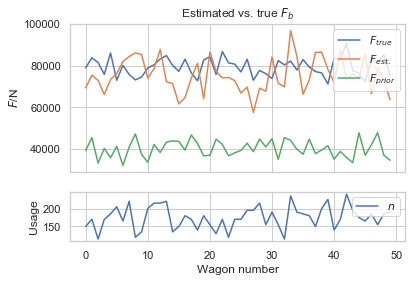

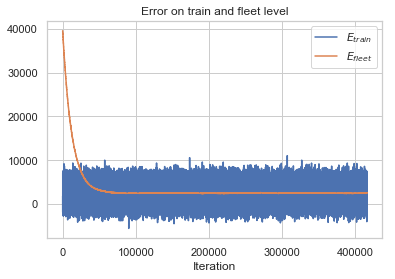

In [7]:
sns.set_style("whitegrid")
start = 0 # Start index for plot
end = 50 # End index for plot
f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
Fleet.iloc[start:end].plot(kind = 'line', y = 'BF_true', ax = axarr[0], label = '$F_{true}$')
Fleet.iloc[start:end].plot(kind = 'line', y = 'BF_est', ax = axarr[0], label = '$F_{est.}$')
Fleet.iloc[start:end].plot(kind = 'line', y = 'BF_prio', ax = axarr[0], label = '$F_{prior}$')
axarr[0].set_ylabel('$F$/N')
axarr[0].legend(loc = 1)
axarr[0].set_title('Estimated vs. true $F_b$')
Fleet.iloc[start:end].plot(kind = 'line', y = 'n', ax = axarr[1], label = '$n$')
axarr[1].legend(loc = 1)
axarr[1].set_ylabel('Usage')
plt.xlabel('Wagon number')

f2, axarr2 = plt.subplots(1)
plt.plot(Train_error, label = '$E_{train}$')
plt.plot(Fleet_error, label = '$E_{fleet}$')
axarr2.legend(loc = 1)
axarr2.set_title('Error on train and fleet level')
mute = plt.xlabel('Iteration')

In [11]:
#Saving data and figure
Fleet.to_json('190121_TrainSim.json')
f.savefig("190121FleetEstimate.pdf", bbox_inches='tight')
f2.savefig("190121Errors.pdf", bbox_inches='tight')

In [10]:
Fleet.head()

,Mass,Sigma_est,Sigma_prio,Sigma_true,n,BF_true,BF_est,BF_prio
0,84370.861070,30618.257142,39528.0,3952.8,150.0,78980.646201,69375.574298,39178.905185
1,89556.428758,30618.257142,39528.0,3952.8,170.0,83828.169238,75460.166195,45471.450154
2,87587.945476,30618.257142,39528.0,3952.8,115.0,81527.655961,72924.628532,33163.935673
3,86387.926358,30618.257142,39528.0,3952.8,170.0,75875.225169,66196.689786,40298.514273
4,82404.167764,30618.257142,39528.0,3952.8,185.0,86120.101934,73360.850340,35762.659802
